# Configuration 



Dataset available on kaggle : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from tqdm.notebook import tqdm
# Install kaggle with pip
#%pip install -q kaggle
#%pip uninstall -y torch torchvision torchaudio
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
print(torch.__version__)  # Print PyTorch version
print(torch.cuda.is_available())  # Check if CUDA is available
print(torch.cuda.current_device())  # Print the current CUDA device
print(torch.cuda.get_device_name(0))  # Print the name of the GPU

2.5.1+cu121
True
0
NVIDIA H100 80GB HBM3


In [2]:

%pip install kaggle
# Create the kaggle directory and move the kaggle.json file to the directory
!mkdir ~/.kaggle
# Create the kaggle.json file and place the information in it
!echo '{"username":"lucianoscarpaci","key":""}' > ~/.kaggle/kaggle.json
# Set the permissions of the file
!chmod 600 ~/.kaggle/kaggle.json
# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# Unzip the dataset in the current directory
!unzip -q chest-xray-pneumonia.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 30.9 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=f4e38f2a4f8b289b3cdff53777465ab6e193c401543c7251fb55905a09b9f932
  Stored in directory: /home/jovyan/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
Note: you may need to restart the kernel to use updated packages.
mkdir: cannot create directory ‘/home/jovyan/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100%|██████████████████████████████████████▉| 2.29G/2.29G [00:12<00:00, 206MB/s]
100%|███████████████████████████████████████| 2.29G/2.29G [00:12<00:00, 200MB/s]


In [3]:
class CFG:
    
    epochs = 30                                       # No. of epochs of training the model 
    lr = 0.001                                         # Learning rate 
    batch_size = 16                                    # Batch Size For Dataset 
    
    model_name = 'tf_efficientnet_b4_ns'               # Model name (We are going to import model from timm)
    img_size = 224
    
    # Going to be use for loading dataset 
    DATA_DIR = "/home/jovyan/chest_xray"                       # Data Directory 
    TEST = "/home/jovyan/chest_xray/test"                                     # Test folder name in data directory 
    TRAIN = "/home/jovyan/chest_xray/train"                                  # Train folder name in data directory 
    VAL = "/home/jovyan/chest_xray/val"                                         # Valid folder name in data directory 
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("On which device we are on : {}".format(device))

On which device we are on : cuda


# Image Transformation and Load Dataset 

In [46]:
%%writefile /home/jovyan/helper.py
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import numpy as np

def show_image(image, label, device, get_denormalize=True):
    image = image.permute(1, 2, 0).to(device)
    mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device)
    std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device)
    
    if get_denormalize:
        image = image * std + mean
        image = np.clip(image.cpu().numpy(), 0, 1)
        plt.imshow(image)
        plt.title(label)
    else: 
        plt.imshow(image.cpu().numpy())
        plt.title(label)

def show_grid(image, device, title=None):
    image = image.permute(1, 2, 0).to(device)
    mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device)
    std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device)
    
    image = image * std + mean
    image = np.clip(image.cpu().numpy(), 0, 1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title:
        plt.title(title)

def accuracy(y_pred, y_true):
    y_pred = F.softmax(y_pred, dim=1)
    top_p, top_class = y_pred.topk(1, dim=1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

def view_classify(image, ps, label, device):
    class_name = ["NORMAL", "PNEUMONIA"]
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1, 2, 0).to(device)
    mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device)
    std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device)
    
    image = image * std + mean
    img = np.clip(image.cpu().numpy(), 0, 1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8, 12), ncols=2)
    ax1.imshow(img)
    ax1.set_title("Ground Truth : {}".format(class_name[label]))
    ax1.axis("off")
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title("Predicted Class")
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    return None

Writing /home/jovyan/helper.py


In [5]:
from torchvision import transforms as T, datasets
from helper import show_image

In [6]:
train_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),
    T.RandomRotation(degrees=(-20,+20)),
    T.ToTensor(),
    T.Normalize([0.485,0.456, 0.406], [0.229, 0.224, 0.225]) #mean and std
])
valid_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485,0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485,0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:

train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)
valid_path = os.path.join(CFG.DATA_DIR, CFG.VAL)
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)

trainset = datasets.ImageFolder(train_path, transform=train_transform)
valset = datasets.ImageFolder(valid_path, transform=valid_transform)
testset = datasets.ImageFolder(test_path, transform=test_transform)

In [8]:
print("Trainset Size : {}".format(len(trainset)))
print("Validset Size : {}".format(len(valset)))
print("Testset Size : {}".format(len(testset)))

Trainset Size : 5216
Validset Size : 16
Testset Size : 624


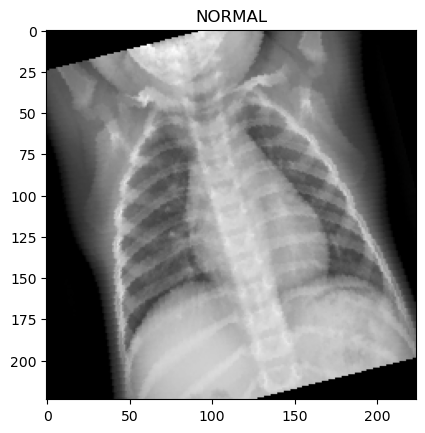

In [9]:
image, label = trainset[2]
class_name = ['NORMAL', 'PRENEUMONIA']
show_image(image, class_name[label])

# Load Dataset into Batches 

In [10]:
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid
from helper import show_grid

In [11]:
train_loader = DataLoader(trainset, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=CFG.batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=CFG.batch_size, shuffle=True)

In [12]:
print("No. of batches in trainloader : {}".format(len(train_loader)))
print("No. of Total examples : {}".format(len(train_loader.dataset)))

No. of batches in trainloader : 326
No. of Total examples : 5216


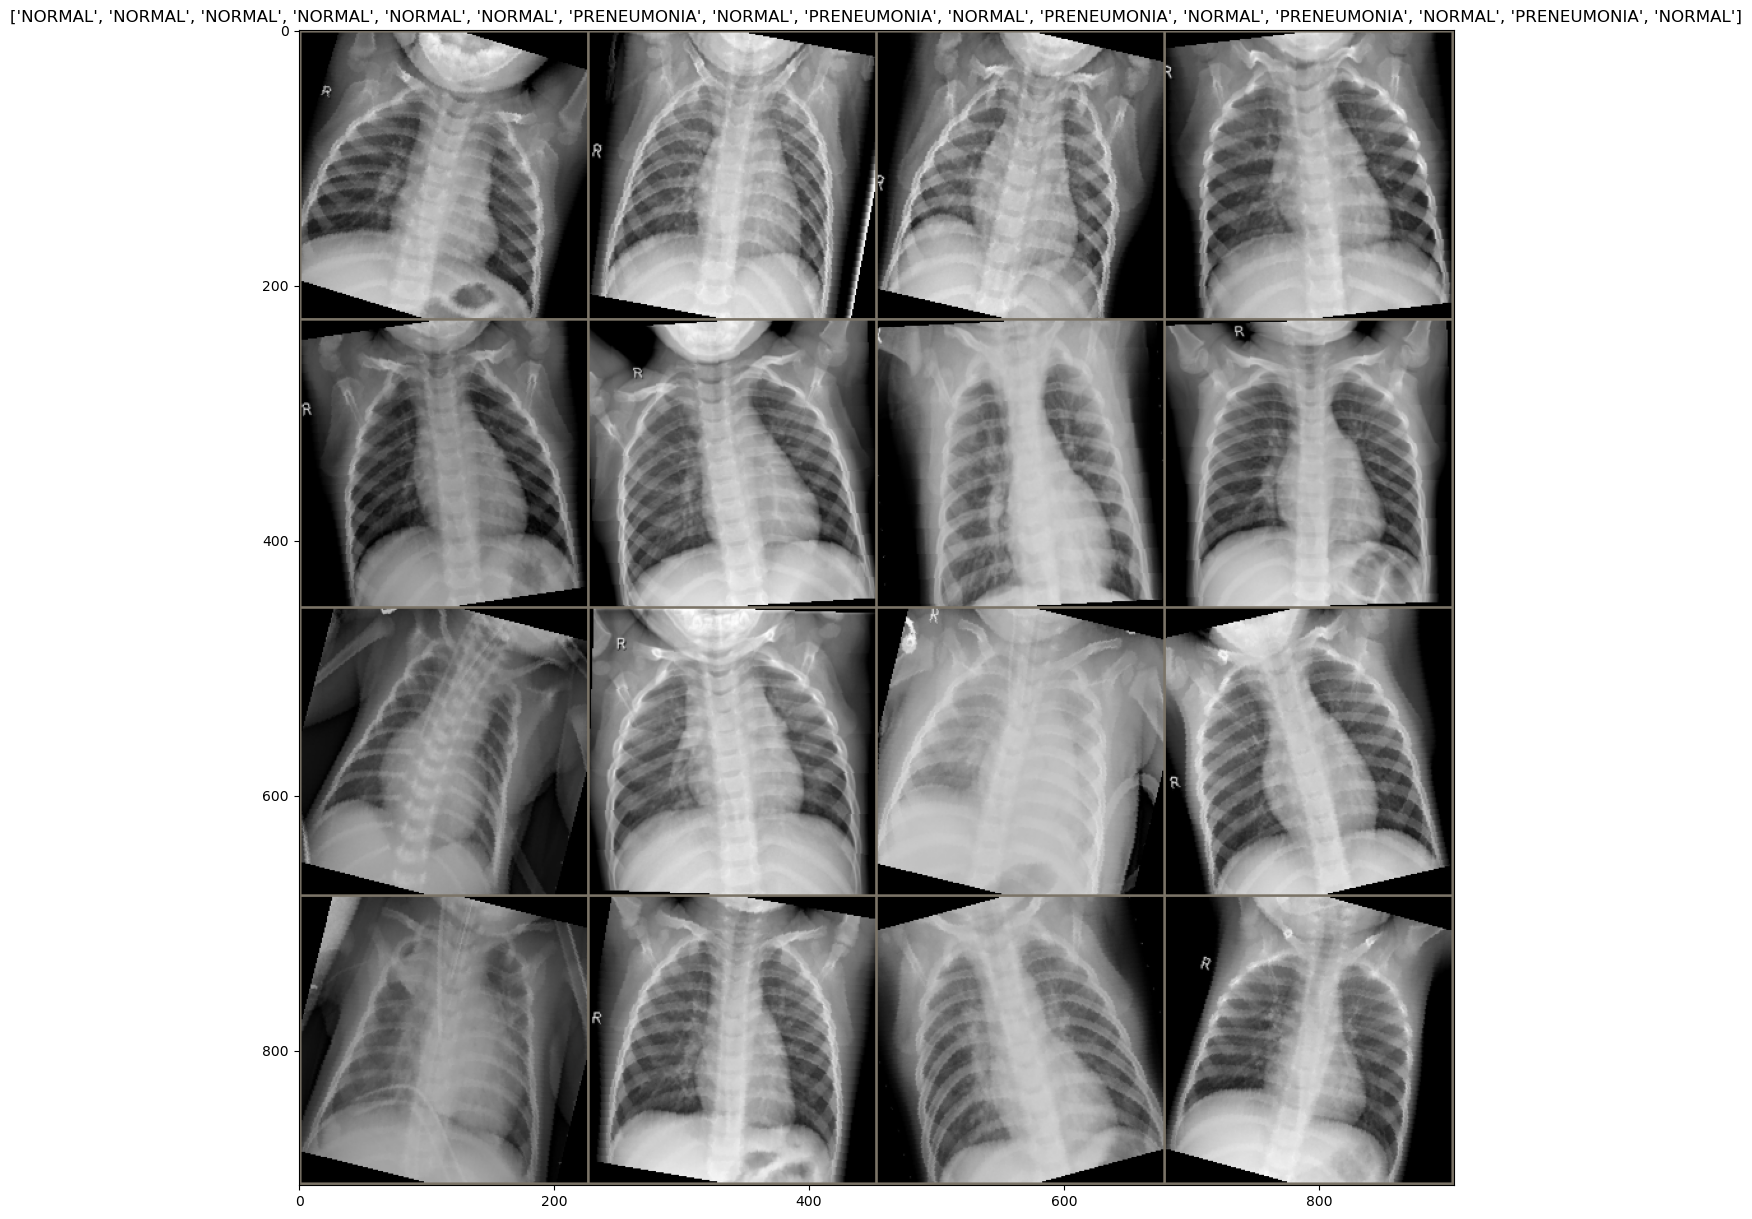

In [13]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
out = make_grid(images, nrow=4)
show_grid(out, title=[class_name[x] for x in labels])

# Fine Tuning EfficientNet Model 

In [19]:
from torch import nn 
import torch.nn.functional as F
#%pip install timm
import timm 

model = timm.create_model(CFG.model_name, pretrained=True).to(device)
#print(model)

# turn off gradients
for param in model.parameters():
    param.requires_grad = False
# change the model
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2)
).to(device)
print(model)

/opt/conda/lib/python3.11/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNo

In [20]:
#%pip install torchsummary
from torchsummary import summary 

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
          Identity-2         [-1, 48, 112, 112]               0
              SiLU-3         [-1, 48, 112, 112]               0
    BatchNormAct2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 48, 112, 112]             432
          Identity-6         [-1, 48, 112, 112]               0
              SiLU-7         [-1, 48, 112, 112]               0
    BatchNormAct2d-8         [-1, 48, 112, 112]              96
          Identity-9         [-1, 48, 112, 112]               0
           Conv2d-10             [-1, 12, 1, 1]             588
             SiLU-11             [-1, 12, 1, 1]               0
           Conv2d-12             [-1, 48, 1, 1]             624
          Sigmoid-13             [-1, 48, 1, 1]               0
    SqueezeExcite-14         [-1, 48, 1

# Build a Simple Trainer

In [21]:
from helper import accuracy
from tqdm import tqdm

In [22]:
class PneumoniaTrainer:
    
    def __init__(self, criterion, optimizer, scheduler):
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
    
    def train_batch_loop(self, model, train_loader):
        train_acc = 0.0
        train_loss = 0.0
        
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = self.criterion(logits, labels)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()
            train_acc += self.accuracy(logits, labels)
        
        return train_acc / len(train_loader), train_loss / len(train_loader)

    
    def valid_batch_loop(self, model, val_loader):
        valid_acc = 0.0
        valid_loss = 0.0
        
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = self.criterion(logits, labels)
            valid_loss += loss.item()
            valid_acc += self.accuracy(logits, labels)
        
        return valid_acc / len(val_loader), valid_loss / len(val_loader)
            
    def fit(self, model, train_loader, val_loader, epochs):
        model = model.to(device)
        valid_min_loss = np.Inf
        for i in range(epochs):
            model.train()
            avg_train_acc, avg_train_loss = self.train_batch_loop(model, train_loader)
            model.eval()
            avg_valid_acc, avg_valid_loss = self.valid_batch_loop(model, val_loader)
            
            if avg_valid_loss <= valid_min_loss:
                print("Valid loss decreased {} -> {}".format(valid_min_loss, avg_valid_loss))
                torch.save(model.state_dict(), 'PreneumoniaModelinPytorch.pt')
                valid_min_loss = avg_valid_loss
            
            print("Epoch : {} Train Loss : {} Train Accuracy : {} ".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {} Valid Accuracy : {} ".format(i+1, avg_valid_loss, avg_valid_acc))
    
    def accuracy(self, logits, labels):
        _, preds = torch.max(logits, 1)
        return (preds == labels).float().mean().item()

# Training Model 


Trained on google colab : https://colab.research.google.com/drive/1C5nNPj7OLYMGnNvWBU5W2zSXfgWDdXCo?usp=sharing

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
scheduler = None
trainer = PneumoniaTrainer(criterion, optimizer, scheduler)
trainer.fit(model, train_loader, val_loader, epochs= CFG.epochs)

100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]


Valid loss decreased inf -> 0.7980058789253235
Epoch : 1 Train Loss : 0.25597288220138087 Train Accuracy : 0.8909125766871165 
Epoch : 1 Valid Loss : 0.7980058789253235 Valid Accuracy : 0.5625 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]


Epoch : 2 Train Loss : 0.21495285224272337 Train Accuracy : 0.9141104294478528 
Epoch : 2 Valid Loss : 1.0088750123977661 Valid Accuracy : 0.5625 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.44it/s]


Valid loss decreased 0.7980058789253235 -> 0.5395987033843994
Epoch : 3 Train Loss : 0.20052954175172408 Train Accuracy : 0.9189033742331288 
Epoch : 3 Valid Loss : 0.5395987033843994 Valid Accuracy : 0.75 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.30it/s]


Epoch : 4 Train Loss : 0.18174611203989552 Train Accuracy : 0.9238880368098159 
Epoch : 4 Valid Loss : 0.8299163579940796 Valid Accuracy : 0.5625 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


Valid loss decreased 0.5395987033843994 -> 0.4211571514606476
Epoch : 5 Train Loss : 0.1816866669940985 Train Accuracy : 0.928680981595092 
Epoch : 5 Valid Loss : 0.4211571514606476 Valid Accuracy : 0.75 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


Valid loss decreased 0.4211571514606476 -> 0.3496493101119995
Epoch : 6 Train Loss : 0.1699654479151123 Train Accuracy : 0.937691717791411 
Epoch : 6 Valid Loss : 0.3496493101119995 Valid Accuracy : 0.9375 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]


Epoch : 7 Train Loss : 0.16807784172677737 Train Accuracy : 0.9325153374233128 
Epoch : 7 Valid Loss : 0.4990609288215637 Valid Accuracy : 0.75 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]


Epoch : 8 Train Loss : 0.16852564880898668 Train Accuracy : 0.9290644171779141 
Epoch : 8 Valid Loss : 0.5050899386405945 Valid Accuracy : 0.8125 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.31it/s]


Epoch : 9 Train Loss : 0.15832995799615796 Train Accuracy : 0.937691717791411 
Epoch : 9 Valid Loss : 0.6281682252883911 Valid Accuracy : 0.625 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.88it/s]


Epoch : 10 Train Loss : 0.16413089295312122 Train Accuracy : 0.9394171779141104 
Epoch : 10 Valid Loss : 0.46216318011283875 Valid Accuracy : 0.75 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]


Epoch : 11 Train Loss : 0.16717804026607128 Train Accuracy : 0.932707055214724 
Epoch : 11 Valid Loss : 0.6819405555725098 Valid Accuracy : 0.625 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.41it/s]


Epoch : 12 Train Loss : 0.16088726004711323 Train Accuracy : 0.9390337423312883 
Epoch : 12 Valid Loss : 0.6939711570739746 Valid Accuracy : 0.625 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]


Epoch : 13 Train Loss : 0.15973131339768507 Train Accuracy : 0.9359662576687117 
Epoch : 13 Valid Loss : 0.38522571325302124 Valid Accuracy : 0.8125 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


Epoch : 14 Train Loss : 0.14935869930106346 Train Accuracy : 0.937691717791411 
Epoch : 14 Valid Loss : 0.4024134576320648 Valid Accuracy : 0.75 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.41it/s]


Epoch : 15 Train Loss : 0.15713026680972175 Train Accuracy : 0.9401840490797546 
Epoch : 15 Valid Loss : 0.4135780334472656 Valid Accuracy : 0.8125 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


Epoch : 16 Train Loss : 0.1391156275208148 Train Accuracy : 0.9476610429447853 
Epoch : 16 Valid Loss : 0.45890384912490845 Valid Accuracy : 0.625 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.20it/s]


Epoch : 17 Train Loss : 0.1469994526744986 Train Accuracy : 0.9432515337423313 
Epoch : 17 Valid Loss : 0.4212777614593506 Valid Accuracy : 0.75 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.39it/s]


Epoch : 18 Train Loss : 0.13131237811940305 Train Accuracy : 0.9514953987730062 
Epoch : 18 Valid Loss : 0.4214125871658325 Valid Accuracy : 0.75 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.42it/s]


Valid loss decreased 0.3496493101119995 -> 0.20724637806415558
Epoch : 19 Train Loss : 0.13283862841981206 Train Accuracy : 0.9490030674846626 
Epoch : 19 Valid Loss : 0.20724637806415558 Valid Accuracy : 0.875 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.30it/s]


Epoch : 20 Train Loss : 0.13791338976706874 Train Accuracy : 0.9453604294478528 
Epoch : 20 Valid Loss : 0.41143810749053955 Valid Accuracy : 0.8125 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


Epoch : 21 Train Loss : 0.14388733088935904 Train Accuracy : 0.9436349693251533 
Epoch : 21 Valid Loss : 0.38011687994003296 Valid Accuracy : 0.8125 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.34it/s]


Epoch : 22 Train Loss : 0.13723127527928058 Train Accuracy : 0.9442101226993865 
Epoch : 22 Valid Loss : 0.431585431098938 Valid Accuracy : 0.75 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.33it/s]


Epoch : 23 Train Loss : 0.1245759606591363 Train Accuracy : 0.9534125766871165 
Epoch : 23 Valid Loss : 0.3550088405609131 Valid Accuracy : 0.75 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


Epoch : 24 Train Loss : 0.14923955157736282 Train Accuracy : 0.9407592024539877 
Epoch : 24 Valid Loss : 0.7216490507125854 Valid Accuracy : 0.5625 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.30it/s]


Epoch : 25 Train Loss : 0.1310644489663019 Train Accuracy : 0.9513036809815951 
Epoch : 25 Valid Loss : 0.37574586272239685 Valid Accuracy : 0.8125 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.25it/s]


Epoch : 26 Train Loss : 0.1307309160310421 Train Accuracy : 0.9495782208588958 
Epoch : 26 Valid Loss : 0.5574924349784851 Valid Accuracy : 0.625 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


Epoch : 27 Train Loss : 0.12084804931398413 Train Accuracy : 0.9513036809815951 
Epoch : 27 Valid Loss : 0.3020584285259247 Valid Accuracy : 0.8125 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.34it/s]


Epoch : 28 Train Loss : 0.13319361373850722 Train Accuracy : 0.9490030674846626 
Epoch : 28 Valid Loss : 0.2784205973148346 Valid Accuracy : 0.8125 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.42it/s]


Epoch : 29 Train Loss : 0.12529787814181778 Train Accuracy : 0.9526457055214724 
Epoch : 29 Valid Loss : 0.3932795822620392 Valid Accuracy : 0.8125 


100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]

Epoch : 30 Train Loss : 0.12502131808943406 Train Accuracy : 0.9520705521472392 
Epoch : 30 Valid Loss : 0.38750892877578735 Valid Accuracy : 0.8125 


# Plot Results 

In [24]:
from helper import view_classify

model.load_state_dict(torch.load('PreneumoniaModelinPytorch.pt', map_location = device))

model.eval()
avg_test_acc, avg_test_loss = trainer.valid_batch_loop(model, test_loader)

print("Test Loss : {}".format(avg_test_acc))
print("Test Acc : {}".format(avg_test_loss))

/tmp/ipykernel_382/2904515868.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('PreneumoniaModelinPytorch.pt', map_location = device))
10

Test Loss : 0.8701923076923077
Test Acc : 0.34908695299273884


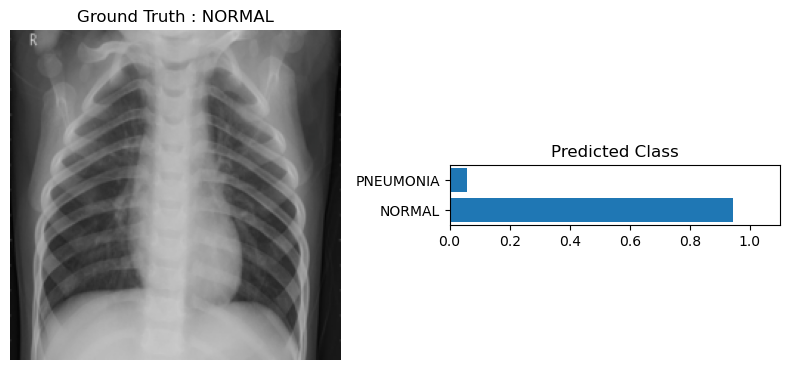

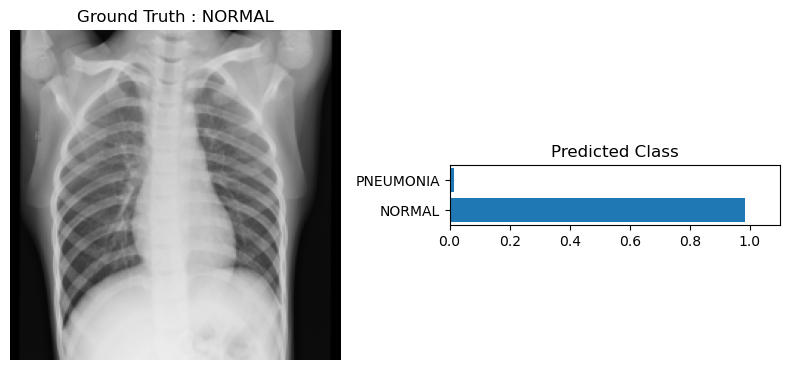

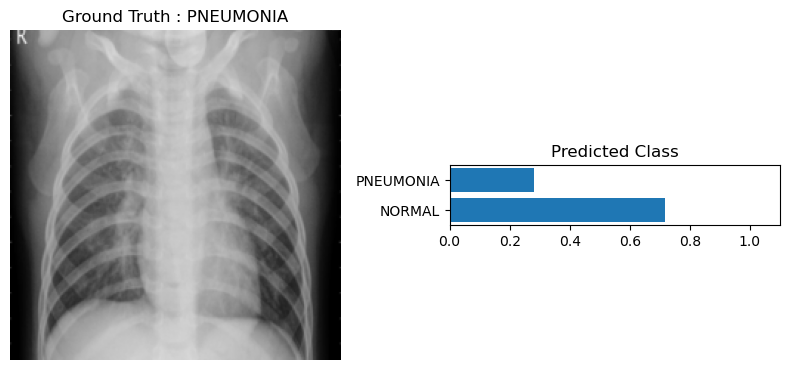

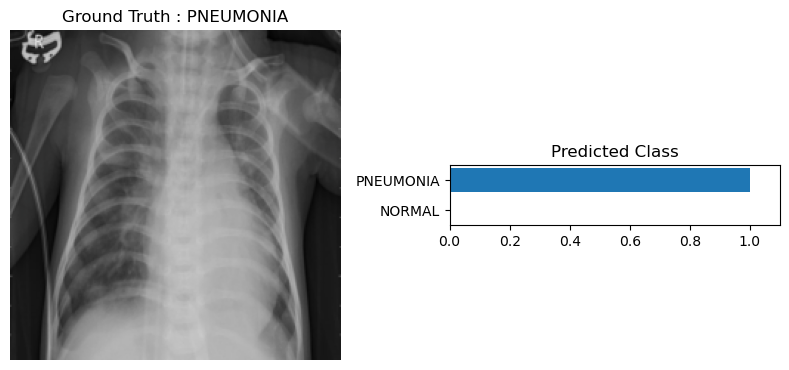

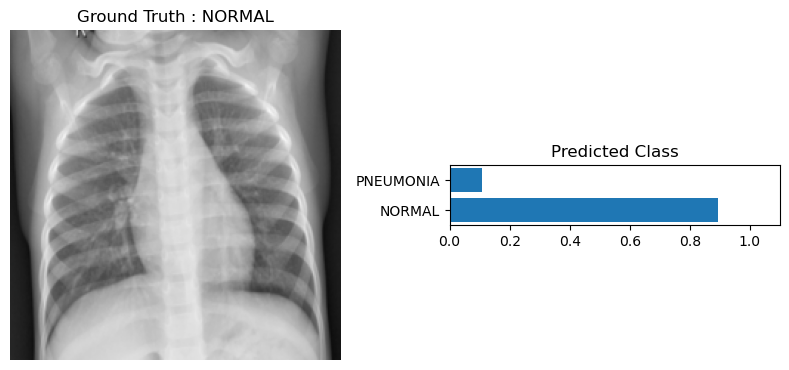

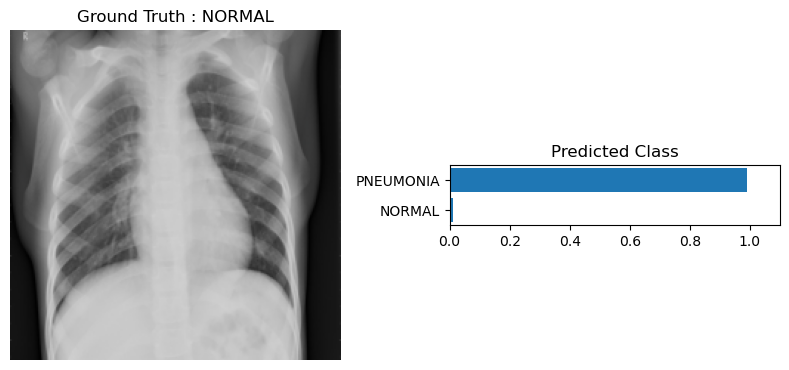

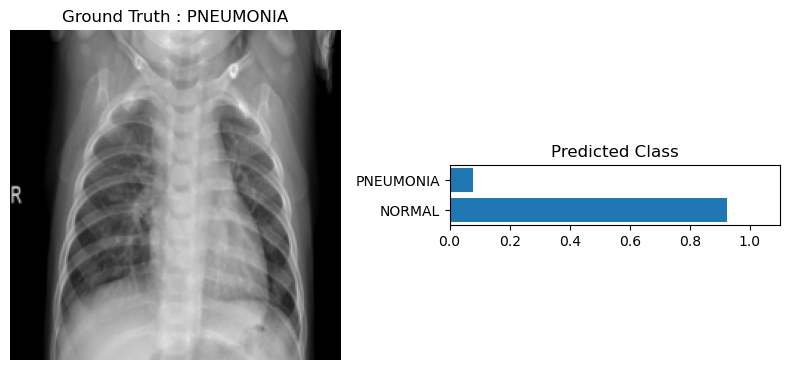

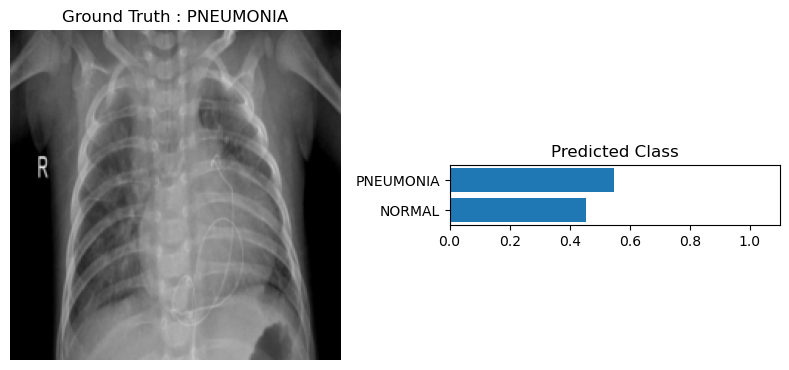

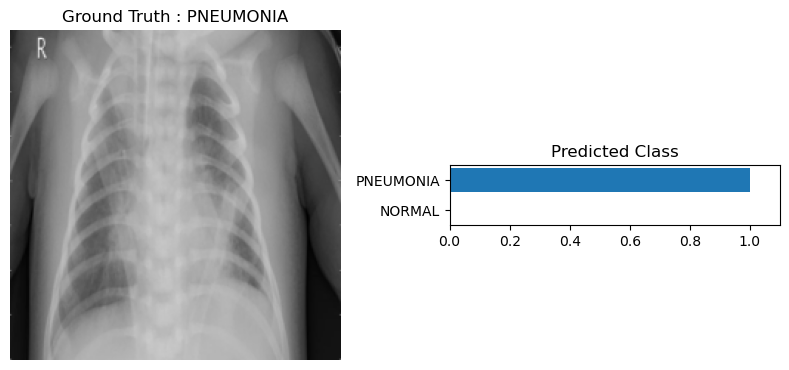

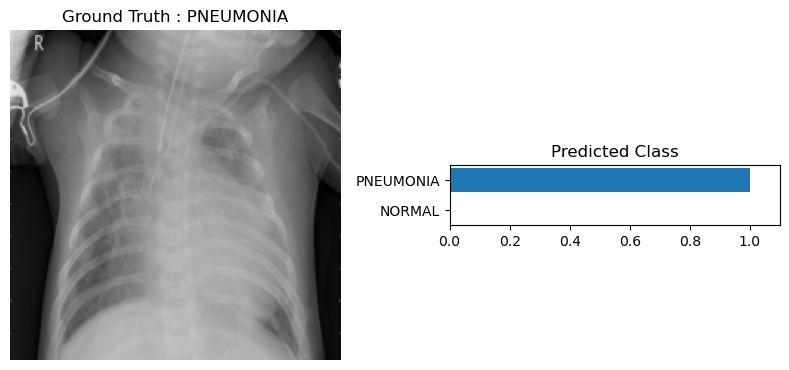

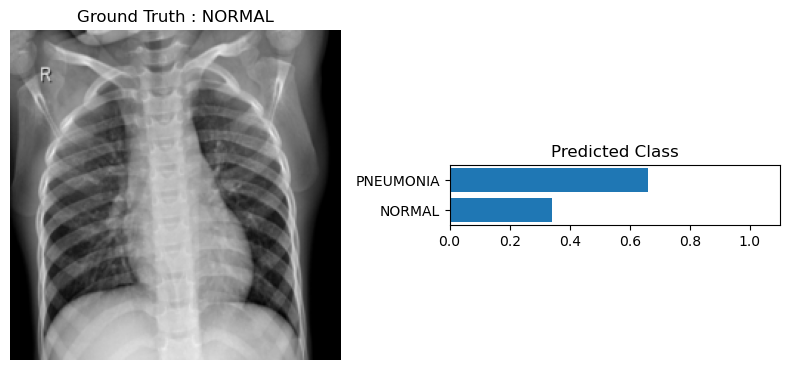

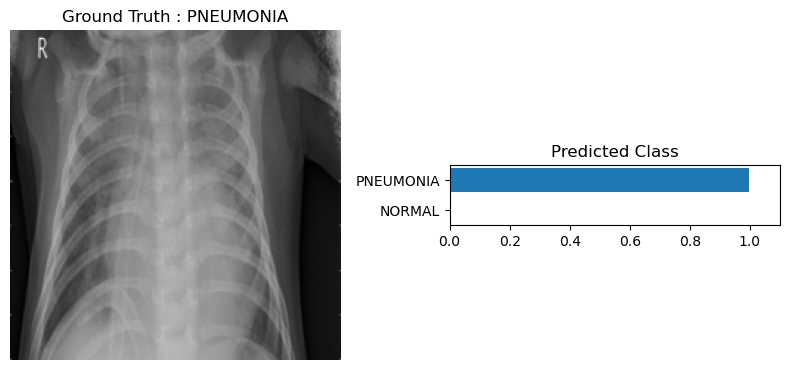

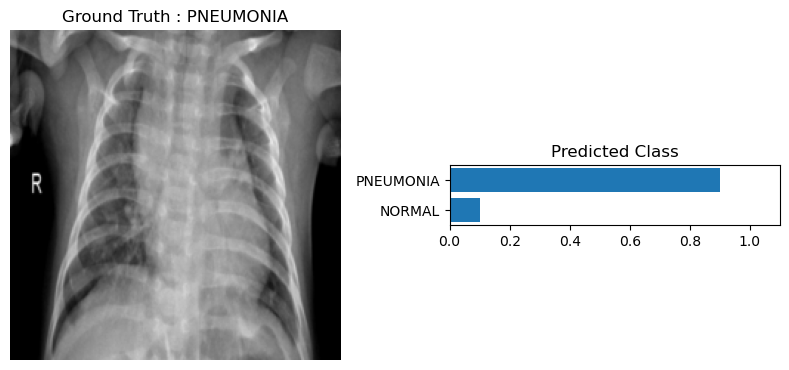

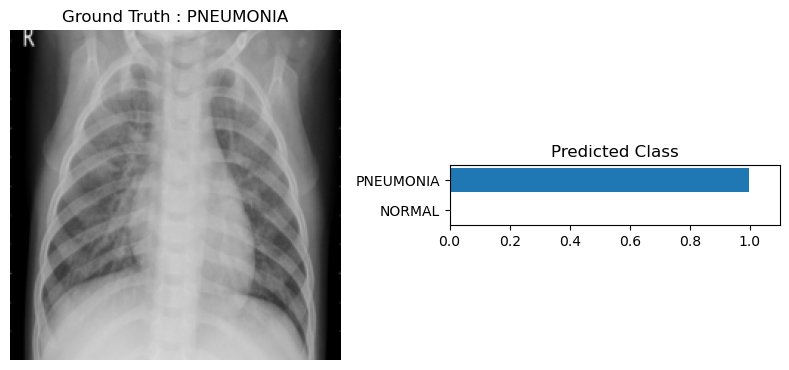

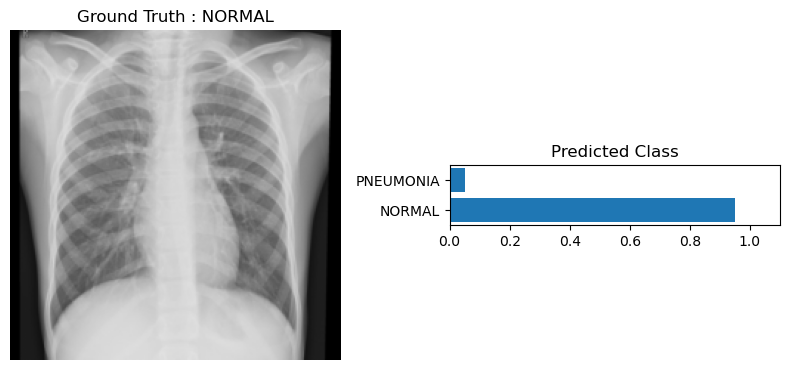

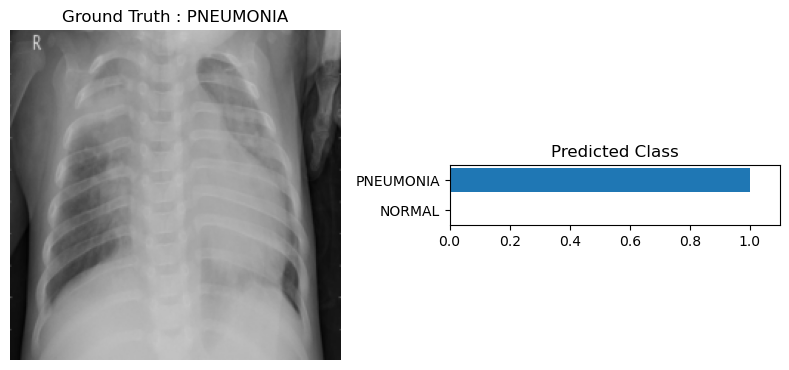

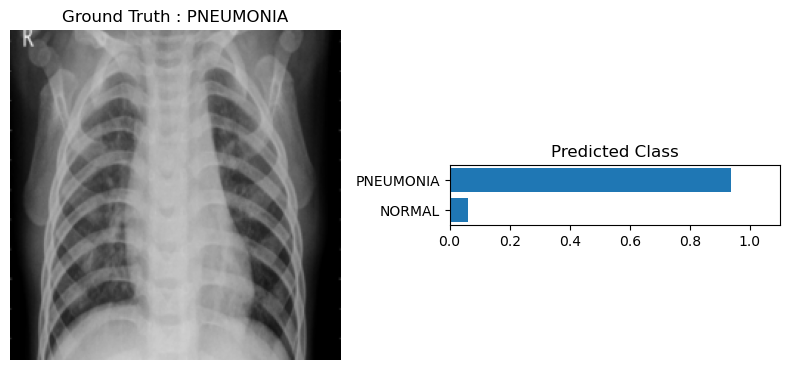

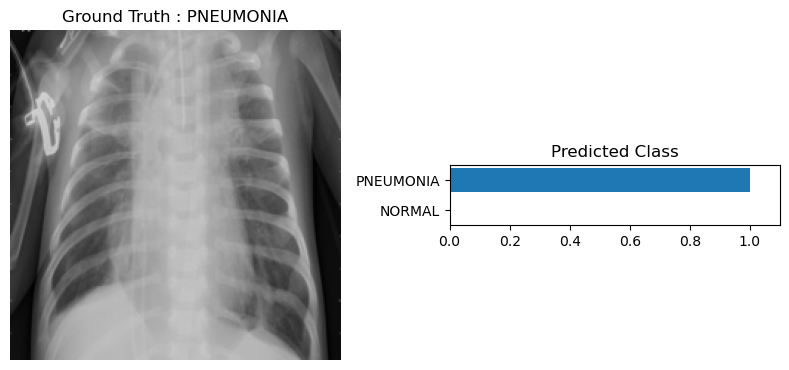

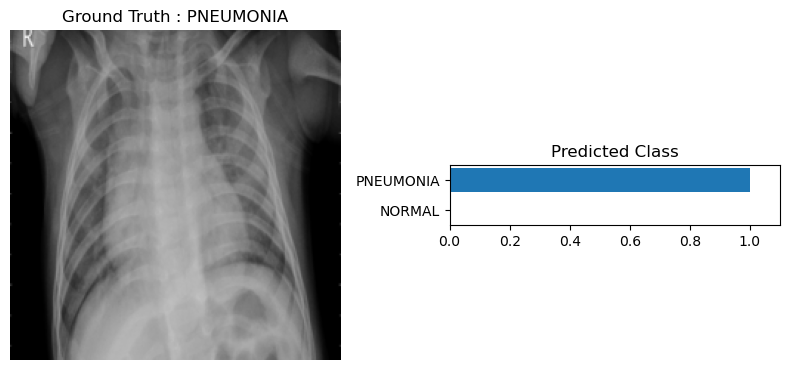

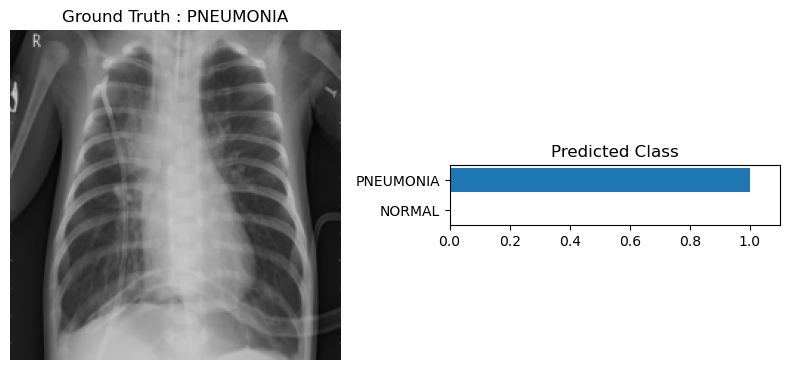

In [54]:
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample_count = 0
max_samples = 20

for images, labels in test_loader:
    
    # Move images and labels to the device
    images, labels = images.to(device), labels.to(device)
    
    def view_classify(image, ps, label, device):
        
        class_name = ["NORMAL", "PNEUMONIA"]
        classes = np.array(class_name)

        ps = ps.cpu().data.numpy().squeeze()
    
        image = image.permute(1, 2, 0).to(device)
        mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device)
        std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device)
    
        image = image * std + mean
        img = np.clip(image.cpu().numpy(), 0, 1)
    
        fig, (ax1, ax2) = plt.subplots(figsize=(8, 12), ncols=2)
        ax1.imshow(img)
        ax1.set_title("Ground Truth : {}".format(class_name[label]))
        ax1.axis("off")
        ax2.barh(classes, ps)
        ax2.set_aspect(0.1)
        ax2.set_yticks(classes)
        ax2.set_yticklabels(classes)
        ax2.set_title("Predicted Class")
        ax2.set_xlim(0, 1.1)

        plt.tight_layout()
        return None

for images, labels in test_loader:
    
    # Move images and labels to the device
    images, labels = images.to(device), labels.to(device)
    
    for i in range(len(images)):
        if sample_count >= max_samples:
            break
        
        image = images[i]
        label = labels[i]
        
        logits = model(image.unsqueeze(0))
        
        ps = F.softmax(logits, dim=1)
        
        view_classify(image, ps, label, device)
        
        sample_count += 1
    
    if sample_count >= max_samples:
        break
        